In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

C:\Users\scanimage\AppData\Local\Temp\ipykernel_13880\912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import sys
import glob
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
sys.path.append(r"C:\Users\scanimage\Documents\JJM\post_cnmfe_analysis")
import dlc_utils as dlc
import os
import datetime
import math
from matplotlib.dates import DateFormatter, date2num

In [3]:
data_folder = r"F:\JJM\behavCam_videos_for_analysis\dSPNOpenFieldRecordings"

In [7]:
exTrack_location_files = glob.glob(data_folder+ r"\\*GRIN*\\" + '*LocationOutput.csv')

In [8]:
len(exTrack_location_files)

26

In [9]:
exTrack_location_files

['F:\\JJM\\behavCam_videos_for_analysis\\dSPNOpenFieldRecordings\\GRIN009_H13_M59_S14\\concactenated_behavCam01_behavCam38_LocationOutput.csv',
 'F:\\JJM\\behavCam_videos_for_analysis\\dSPNOpenFieldRecordings\\GRIN011_H10_M19_S59\\concactenated_behavCam01_behavCam38_30fps_LocationOutput.csv',
 'F:\\JJM\\behavCam_videos_for_analysis\\dSPNOpenFieldRecordings\\GRIN012_H16_M57_S23\\behavCamGRIN012_H16_M57_S23_gray_LocationOutput.csv',
 'F:\\JJM\\behavCam_videos_for_analysis\\dSPNOpenFieldRecordings\\GRIN012_H17_M32_S17\\GRIN012_H17_M32_S17_gray_LocationOutput.csv',
 'F:\\JJM\\behavCam_videos_for_analysis\\dSPNOpenFieldRecordings\\GRIN012_H17_M46_S35\\concactenated_behavCam01_behavCam27_30fps_LocationOutput.csv',
 'F:\\JJM\\behavCam_videos_for_analysis\\dSPNOpenFieldRecordings\\GRIN012_H17_M46_S35\\concactenated_behavCam01_behavCam27_LocationOutput.csv',
 'F:\\JJM\\behavCam_videos_for_analysis\\dSPNOpenFieldRecordings\\GRIN013_H13_M33_S54\\GRIN013_H13_M33_S54_gray_LocationOutput.csv',
 'F:\

In [56]:
sessionPath = exTrack_location_files[25]
print(sessionPath)

'\\'.join(sessionPath.split(os.sep)[:-1])+'\\timestamp.dat'

# load eZ track output and behavior camera timestamps from miniscope software 
ezTrackOutput = pd.read_csv(sessionPath)
timestampfile = pd.read_table('\\'.join(sessionPath.split(os.sep)[:-1])+'\\timestamp.dat')

#ezTrackOutput

# separate behavCam time stamps
behavCamTimeStamps = timestampfile[timestampfile['camNum'] == 1]
behavCamTimeStamps['frameNum'][0:len(ezTrackOutput)]
# get times of frames
behavCamTimes = behavCamTimeStamps['sysClock']
# set 1st frame to 0 
behavCamTimes[1] = 0 
# reset index to 0 
behavCamTimes = behavCamTimes.reset_index()

# delta T between frames for analyzed videos 
behavCamFrameTimeDelta = behavCamTimes['sysClock'].diff()[0:len(ezTrackOutput)]

# get velocity from frame times 
velocity = abs(ezTrackOutput['Distance_cm'].diff())/(behavCamFrameTimeDelta/1000)

# data frame of mouse velocity 
veloctiyDataFrame = pd.concat([ezTrackOutput[['Frame', 'X', 'Y', 'Distance_px', 'Distance_cm']], 
                               behavCamTimes[0:len(ezTrackOutput)]['sysClock'],
                               pd.DataFrame(velocity, columns=['Velocity'])], axis=1)

#plt.plot(veloctiyDataFrame['sysClock'].diff()[10:500])

#frame rate for behavCam 
#veloctiyDataFrame['sysClock'].diff().mean()

# create time delta for behavior index
# behavCam for v3 should record at 30 fps, can verify in timestamp file, check this is set correctly in concactenated videos
veloctiyDataFrame = veloctiyDataFrame.set_index(pd.to_timedelta(np.linspace(0, (len(veloctiyDataFrame)-1)*(1/30), len(veloctiyDataFrame)), unit='s'))
veloctiyDataFrame

#len(veloctiyDataFrame)

## smooth velocity by downsampling to 5Hz to calculate distance travelled 
downsampledDataFrame = veloctiyDataFrame.resample('.2S').mean()[['X', 'Y']]
# calculate new euclidean distance based on mean values here 
downsampledDataFrame

cmPerPixel = veloctiyDataFrame['Distance_cm'][1]/veloctiyDataFrame['Distance_px'][1]
#cmPerPixel = 10
print(cmPerPixel)

def euclideanDistance(row):
    return(math.sqrt(row['X']**2+row['Y']**2))

def smoothedVelocity(row, cmPerPixel):
    #euclidean distance divided by sampling rate, multiplied by cm/pixel
    return((math.sqrt(row['X']**2+row['Y']**2)/.2)*cmPerPixel)
    
downsampledDataFrame['smoothedVelocity'] = downsampledDataFrame.diff().apply(lambda row : smoothedVelocity(row, cmPerPixel), axis=1)

downsampledDataFrame

#downsample once more to 1S as a "median filter"
downsampledMedian = downsampledDataFrame.resample('2S').median()

#resample to 5Hz for alignment with imaging data
velocity_resampled = downsampledMedian.resample('.2S').bfill()

## save speed bins
#velocity_resampled[(velocity_resampled['smoothedVelocity']>0) & (velocity_resampled['smoothedVelocity']<0.5)]

# for "rest" analysis maybe further split < 0.5 cm/sec bins e.g. (0, 0.25) (0, 0.5)

# define velocity bins and save output to csv files for clustering analysis
velocityBins = [(0, 0.125), (0.125, 0.25), (0.25, 0.5), (0.5, math.inf)]

#get indicies corresponding to velocity bins 
indiciesRestbin0 = pd.DataFrame([velocity_resampled.index.get_loc(velocity_resampled[(velocity_resampled['smoothedVelocity']>0) & (velocity_resampled['smoothedVelocity']<0.5)].index[i]) 
 for i in range(len(velocity_resampled[(velocity_resampled['smoothedVelocity']>0) & (velocity_resampled['smoothedVelocity']<0.5)].index))], columns=['Indicies'])
indiciesRestbin1 = pd.DataFrame([velocity_resampled.index.get_loc(velocity_resampled[(velocity_resampled['smoothedVelocity']>0.5) & (velocity_resampled['smoothedVelocity']<1)].index[i]) 
 for i in range(len(velocity_resampled[(velocity_resampled['smoothedVelocity']>0.5) & (velocity_resampled['smoothedVelocity']<1)].index))], columns=['Indicies'])
indiciesRestbin2 = pd.DataFrame([velocity_resampled.index.get_loc(velocity_resampled[(velocity_resampled['smoothedVelocity']>1) & (velocity_resampled['smoothedVelocity']<2)].index[i]) 
 for i in range(len(velocity_resampled[(velocity_resampled['smoothedVelocity']>1) & (velocity_resampled['smoothedVelocity']<2)].index))], columns=['Indicies'])
indiciesRestbin3 = pd.DataFrame([velocity_resampled.index.get_loc(velocity_resampled[(velocity_resampled['smoothedVelocity']>2) & (velocity_resampled['smoothedVelocity']<5)].index[i]) 
 for i in range(len(velocity_resampled[(velocity_resampled['smoothedVelocity']>2) & (velocity_resampled['smoothedVelocity']<5)].index))], columns=['Indicies'])
#indiciesVbin4 = pd.DataFrame([velocity_resampled.index.get_loc(velocity_resampled[(velocity_resampled['smoothedVelocity']>5) & (velocity_resampled['smoothedVelocity']<10)].index[i]) 
# for i in range(len(velocity_resampled[(velocity_resampled['smoothedVelocity']>5) & (velocity_resampled['smoothedVelocity']<10)].index))], columns=['Indicies'])
#indiciesVbin5 = pd.DataFrame([velocity_resampled.index.get_loc(velocity_resampled[(velocity_resampled['smoothedVelocity']>10) & (velocity_resampled['smoothedVelocity']<math.inf)].index[i]) 
# for i in range(len(velocity_resampled[(velocity_resampled['smoothedVelocity']>10) & (velocity_resampled['smoothedVelocity']<math.inf)].index))], columns=['Indicies'])

#save to csv files 
basePath=r'F:\\JJM\\behavCam_videos_for_analysis\\dSPNOpenFieldRecordings'
indiciesRestbin0.to_csv(basePath+'\\'+os.path.split(sessionPath)[0].split('\\')[-1]+'_movingFrameIndicies5Hz_Restbin0.csv')
indiciesRestbin1.to_csv(basePath+'\\'+os.path.split(sessionPath)[0].split('\\')[-1]+'_movingFrameIndicies5Hz_Restbin1.csv')
indiciesRestbin2.to_csv(basePath+'\\'+os.path.split(sessionPath)[0].split('\\')[-1]+'_movingFrameIndicies5Hz_Restbin2.csv')
indiciesRestbin3.to_csv(basePath+'\\'+os.path.split(sessionPath)[0].split('\\')[-1]+'_movingFrameIndicies5Hz_Restbin3.csv')

F:\JJM\behavCam_videos_for_analysis\dSPNOpenFieldRecordings\GRIN041_H16_M35_S12\concactenated_behavCam01_behavCam43_LocationOutput.csv
0.11473923410161976


C:\Users\scanimage\AppData\Local\Temp\ipykernel_13880\3321749993.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavCamTimes[1] = 0


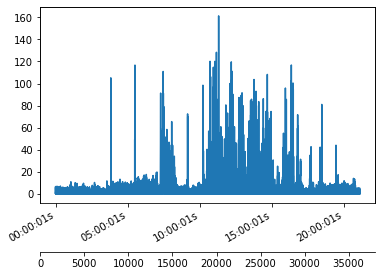

In [20]:
## velocity dataframe plot unsmoothed
xRangeFrames=(0,58000)
y = veloctiyDataFrame['Velocity'][xRangeFrames[0]:xRangeFrames[1]]
#recording_start_time = datetime.datetime.fromtimestamp(abs(timestampfile[timestampfile['camNum'] == 1]['sysClock'][1]))
#plot x axis time
recording_start_time = datetime.datetime(1970, 1, 1, hour=0, minute=0, second=0, microsecond=0)
x = [recording_start_time+veloctiyDataFrame.index[i] for i in range(len(veloctiyDataFrame.index))][xRangeFrames[0]:xRangeFrames[1]]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
fig.subplots_adjust(bottom=0.2)

myFmt = DateFormatter("%M:%S:%ms")
ax1.xaxis.set_major_formatter(myFmt)
ax1.plot(x, y)
plt.gcf().autofmt_xdate()

# Move twinned axis ticks and label from top to bottom
ax2.set_xlim(0, len(veloctiyDataFrame))
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.25))

plt.show()

In [22]:
len(velocity_resampled)

6331

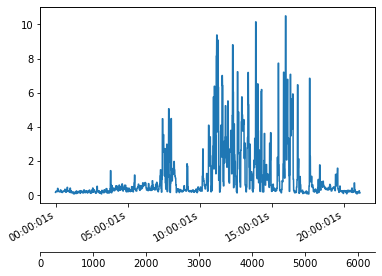

In [23]:
## plot smoothed frames 
velocity_resampled = downsampledMedian.resample('.2S').bfill()
xRangeFrames=(0,len(velocity_resampled))
columnToPlot = 'smoothedVelocity'
y = velocity_resampled[columnToPlot][xRangeFrames[0]:xRangeFrames[1]]
#recording_start_time = datetime.datetime.fromtimestamp(abs(timestampfile[timestampfile['camNum'] == 1]['sysClock'][1]))
#plot x axis time
recording_start_time = datetime.datetime(1970, 1, 1, hour=0, minute=0, second=0, microsecond=0)
x = [recording_start_time+velocity_resampled.index[i] for i in range(len(velocity_resampled.index))][xRangeFrames[0]:xRangeFrames[1]]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
fig.subplots_adjust(bottom=0.2)

myFmt = DateFormatter("%M:%S:%ms")
ax1.xaxis.set_major_formatter(myFmt)
ax1.plot(x, y)
plt.gcf().autofmt_xdate()

# Move twinned axis ticks and label from top to bottom
ax2.set_xlim(0, len(velocity_resampled))
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.25))

plt.show()

In [29]:
indiciesRestbin3

,Indicies
0,2221
1,2222
2,2223
3,2224
4,2225
...,...
665,5296
666,5297
667,5298
668,5299


In [87]:
#move to quest
#res_files=8f796c9e-f5c8-11e5-9842-22000b9da45e
#quest=d5990400-6d04-11e5-ba46-22000b92c6ec
#res_files_base_dir = '8f796c9e-f5c8-11e5-9842-22000b9da45e:/rdss/jma819/fsmresfiles/Projects/JJM/MiniscopeMovies/scope_data/'
#quest_dir = 'd5990400-6d04-11e5-ba46-22000b92c6ec:/projects/b1118/behaviorvideos/timestampfiles/'

In [88]:
#for session in list(time_stamp_file_locations.keys()):
#    transfer_info = res_files_base_dir+time_stamp_file_locations[session]+' '+quest_dir+session+'_timestamp.dat'
#    !eval "globus transfer" $transfer_info

In [ ]:
##frame by frame alignment to miniscope camera

sessions = [f_path.split('/')[-1].rstrip('_raw_trace.csv') for f_path in mm_raw_traces]

sessions = ['GRIN039_H14_M8_S53', 'GRIN026_H16_M35_S34', 'GRIN032_H16_M49_S22']

for session in sessions:
    print(session)
    timestampfile = '/projects/b1118/behaviorvideos/timestampfiles/'+session+'_timestamp.dat'
    frame_clock_df = pd.read_table(timestampfile)
    output_directory = '/projects/b1118/miniscope/analysis/compiled_data/mm_tracking_output/'

    Cam0_timestamps = frame_clock_df[frame_clock_df['camNum'] == 0]  
    Cam1_timestamps = frame_clock_df[frame_clock_df['camNum'] == 1]
    #beavCam is usually faster framerate 
    if Cam1_timestamps['sysClock'].iloc[1:].diff().mean()<Cam0_timestamps['sysClock'].iloc[1:].diff().mean():
        msCam_camnum=0
        behavCam_camnum=1
    elif Cam0_timestamps['sysClock'].iloc[1:].diff().mean()<Cam1_timestamps['sysClock'].iloc[1:].diff().mean():
        msCam_camnum=1
        behavCam_camnum=0

    raw_trace = pd.read_csv(data_folder+session+'_raw_trace.csv', names=['velocity'])
    raw_trace_filtered = pd.read_csv(data_folder+session+'_raw_trace_median_filter.csv', names=['velocity(20_Hz_filtered)'])
    speed_trace = pd.read_csv(data_folder+session+'_speedtrace.csv', names=['speed_trace(velocity_5Hz_filtered)'])
    raw_traces = pd.concat([raw_trace, raw_trace_filtered], axis=1)

    # align the raw traces for comparison

    mm_tracking_aligned = dlc.downsample_mmtracking(raw_traces, timestampfile, msCam_camnum, behavCam_camnum)

    # convert to timedelta for downsampling 
    aligned_td = mm_tracking_aligned.set_index(pd.to_timedelta(np.linspace(0, mm_tracking_aligned['sys_clock_behavCam'].values[-1]/1000, len(mm_tracking_aligned)), unit='s'), drop=False)
    aligned_td.to_csv(output_directory+session+'_mm_tracking_foranalysis_unsmoothed'+'.csv')